# Estimating Time to Failure of Turbofan Engines using Long-Short Term Modelling

In [135]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Data Prep
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Keras 
from keras.models import load_model
from keras.callbacks import EarlyStopping 
from keras.models import Sequential
from keras.layers import Dense, Dropout, ConvLSTM2D, LSTM, Activation

## Loading Data

In [2]:
# Labelling Columns with appropriate names
cols = ['Unit', 'Cycle', 'Setting1', 'Setting2', 'Setting3', 'FanInletTemp',
        'LPCOutletTemp', 'HPCOutletTemp', 'LPTOutletTemp', 'FanInletPres', 
        'BypassDuctPres', 'TotalHPCOutletPres', 'PhysFanSpeed', 'PhysCoreSpeed', 
        'EnginePresRatio', 'StaticHPCOutletPres', 'FuelFlowRatio', 'CorrFanSpeed',
        'CorrCoreSpeed', 'BypassRatio', 'BurnerFuelAirRatio', 'BleedEnthalpy',
        'DemandFanSpeed', 'DemandCorrFanSpeed', 'HPTCoolantBleed', 'LPTCoolantBleed']

In [3]:
def training_data():
    # Loading train_FD001 
    df1 = pd.read_table(f"CMaps/train_FD001.txt", sep = " ", header = None)
    df1 = df1.drop([26,27], axis = 1)
    df1.columns = cols

    # Loading train_FD003
    df2 = pd.read_table(f"CMaps/train_FD003.txt", sep = " ", header = None)
    df2 = df2.drop([26,27], axis = 1)
    df2.columns = cols
    df2['Unit'] = df2['Unit'] + df1['Unit'].max()
    
    # Merging data frames
    df = pd.concat([df1,df2]).reset_index(drop = True)
    
    # Creating RUL attribute
    # Groupby unit and find the number of cycles that it runs before failure
    rul = pd.DataFrame(df.groupby('Unit')['Cycle'].count()).reset_index(False)
    
    # Rename the columns for easier merging
    rul.columns = ['Unit','Max_Cycles']
    
    # Merge using the unit 
    df = df.merge(rul, on = ['Unit'])
    
    # Subtract the cycle number from the maximum number of cycles to find the
    # number of cycles remaining before failure
    df['RUL'] = df['Max_Cycles'] - df['Cycle']
    
    # Drop unnecessary columns 
    df.drop(['Max_Cycles'], axis = 1, inplace = True)
    df = df.dropna(axis = 0)
    return df

In [4]:
def testing_data():
    # Loading test_FD001
    df1 = pd.read_table(f"CMaps/test_FD001.txt", sep = " ", header = None)
    df1 = df1.drop([26,27], axis = 1)
    df1.columns = cols

    # Loading test_FD003
    df2 = pd.read_table(f"CMaps/test_FD003.txt", sep = " ", header = None)
    df2 = df2.drop([26,27], axis = 1)
    df2.columns = cols
    df2['Unit'] = df2['Unit'] + df1['Unit'].max()

    # Merging data frames
    df = pd.concat([df1, df2])
    
    # Loading in the remaining life times for the test data
    test1 = pd.read_table(f"CMaps/RUL_FD001.txt", header = None, names = ['RUL'] )
    test2 = pd.read_table(f"CMaps/RUL_FD003.txt", header = None, names = ['RUL'])
    
    # Merging the RULs together
    y_test = pd.concat([test1,test2])
    y_test['Unit'] = np.arange(1, 1 + len(y_test))
    y_test.columns = ['Remaining_Life', 'Unit']
    
    # Creating RUL attribute
    # Groupby unit and find the number of cycles that it runs before failure
    rul = pd.DataFrame(df.groupby('Unit')['Cycle'].max()).reset_index()
    rul.columns = ['Unit', 'Max_Cycles']
    df = df.merge(rul, on = ['Unit'])
    df = df.merge(y_test, on = ['Unit'])

        
    # Subtract the cycle number from the maximum number of cycles to find the
    # number of cycles remaining before failure
    # Then, for the test data only, add the remaining life to the RUL
    df['RUL'] = df['Max_Cycles'] - df['Cycle']
    df['RUL'] = df['RUL'] + df['Remaining_Life']
    df.drop(['Max_Cycles', 'Remaining_Life'], axis = 1, inplace=True)
    return df

In [99]:
train_df = training_data()
test_df = testing_data()

train_df

,Unit,Cycle,Setting1,Setting2,Setting3,FanInletTemp,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,FanInletPres,...,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BurnerFuelAirRatio,BleedEnthalpy,DemandFanSpeed,DemandCorrFanSpeed,HPTCoolantBleed,LPTCoolantBleed,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45346,200,148,-0.0016,-0.0003,100.0,518.67,643.78,1596.01,1424.11,14.62,...,2388.30,8138.08,8.5036,0.03,394,2388,100.0,38.44,22.9631,4
45347,200,149,0.0034,-0.0003,100.0,518.67,643.29,1596.38,1429.14,14.62,...,2388.28,8144.36,8.5174,0.03,395,2388,100.0,38.50,22.9746,3
45348,200,150,-0.0016,0.0004,100.0,518.67,643.84,1604.53,1431.41,14.62,...,2388.24,8135.95,8.5223,0.03,396,2388,100.0,38.39,23.0682,2
45349,200,151,-0.0023,0.0004,100.0,518.67,643.94,1597.56,1426.57,14.62,...,2388.26,8141.24,8.5148,0.03,395,2388,100.0,38.31,23.0753,1


## EDA

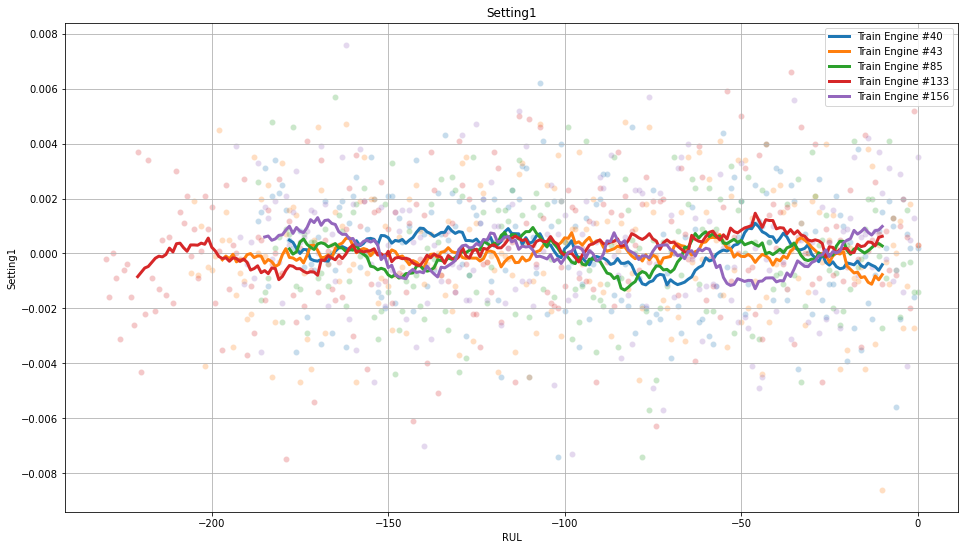

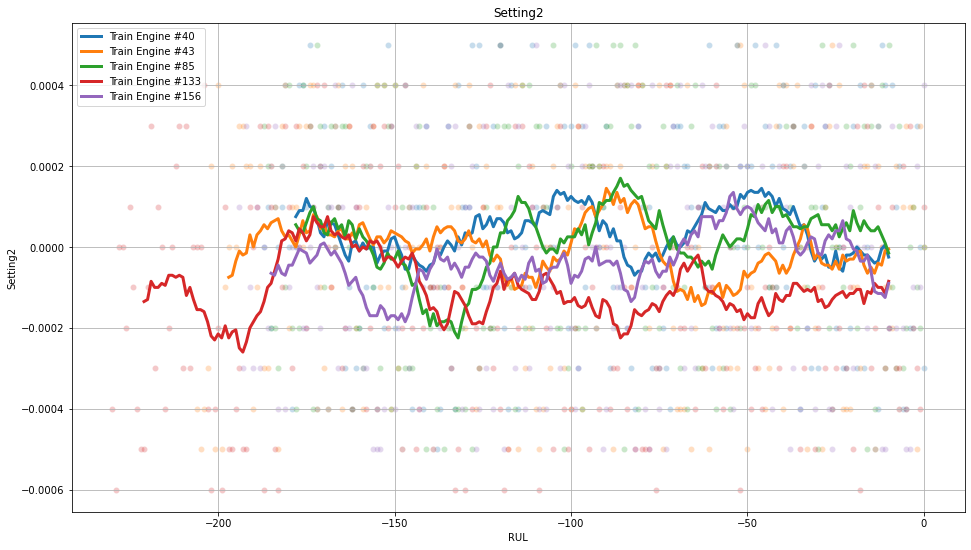

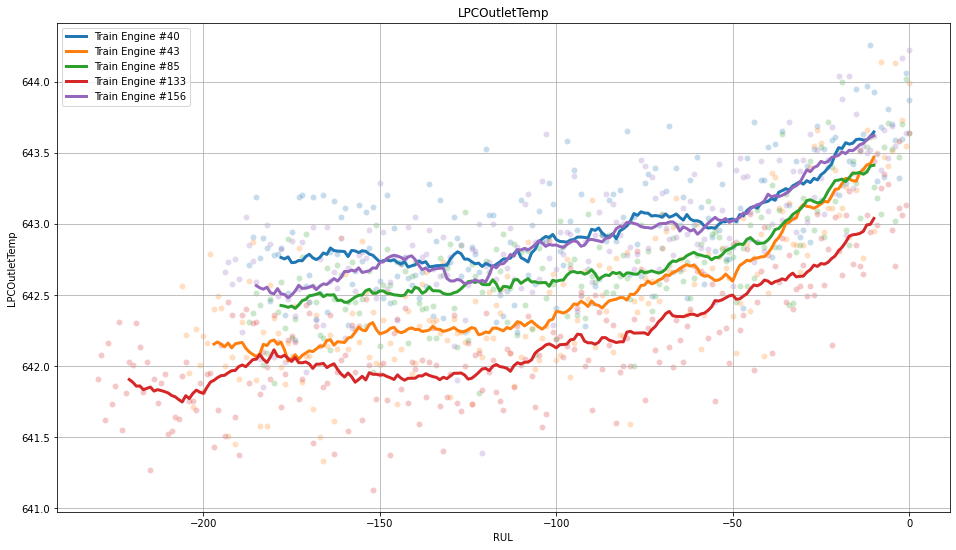

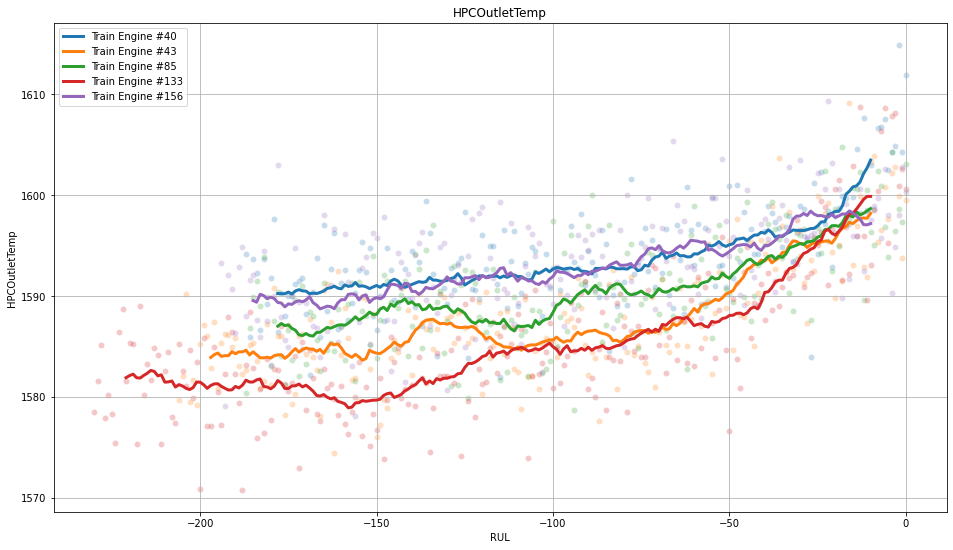

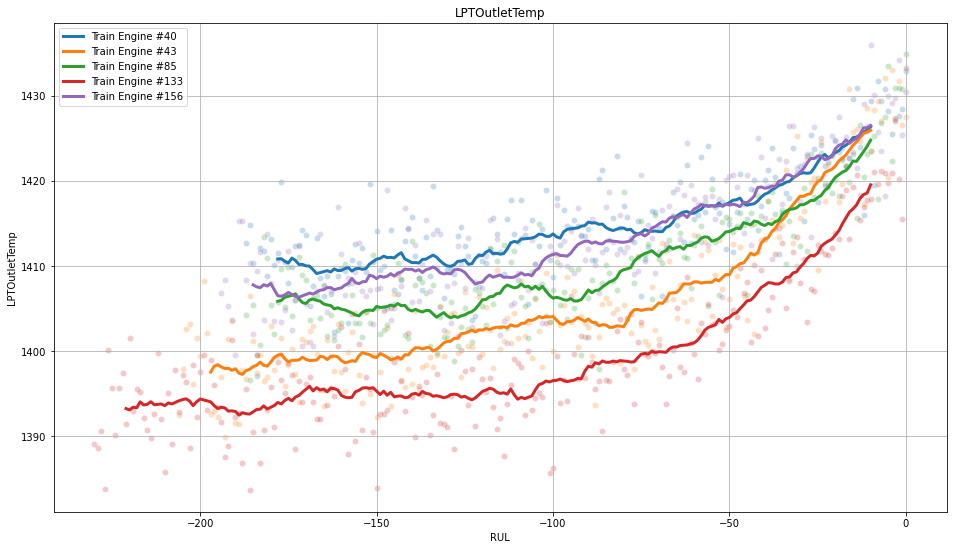

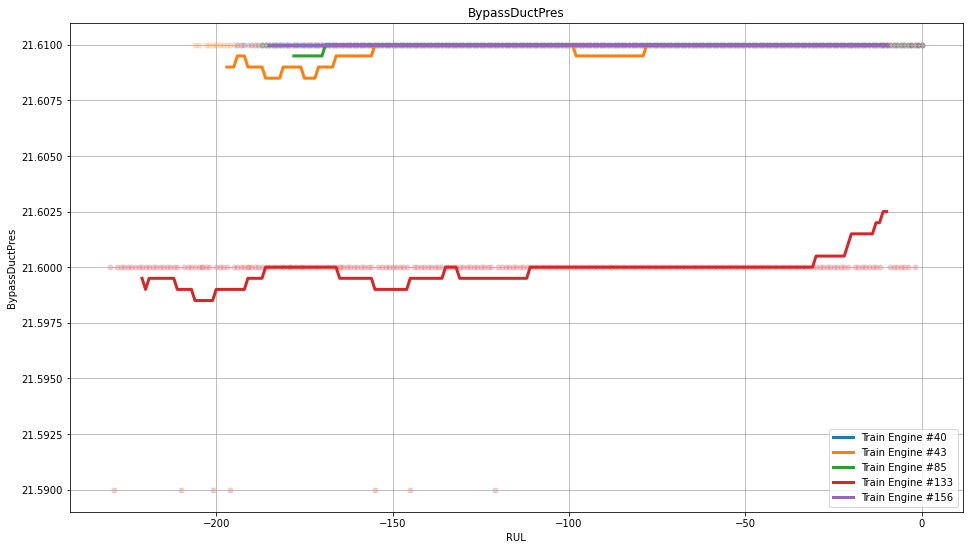

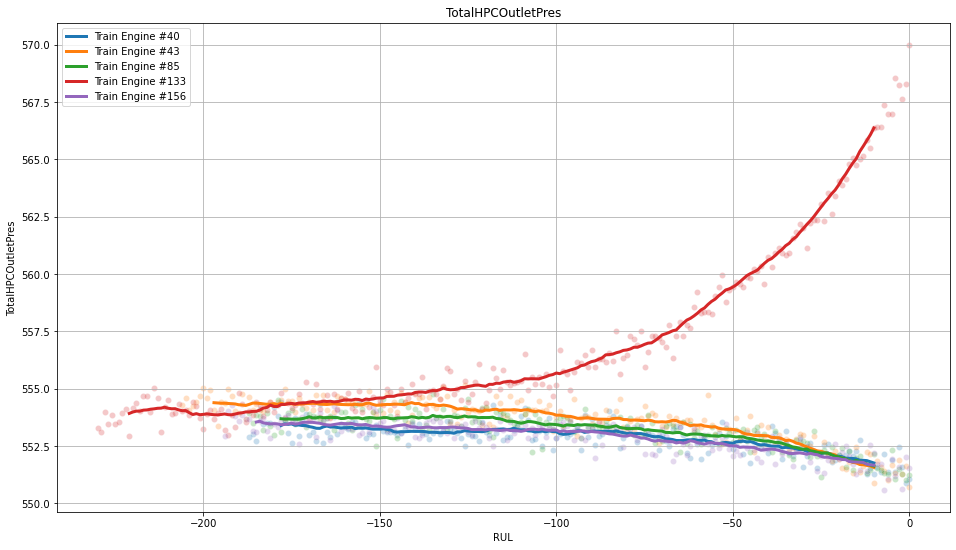

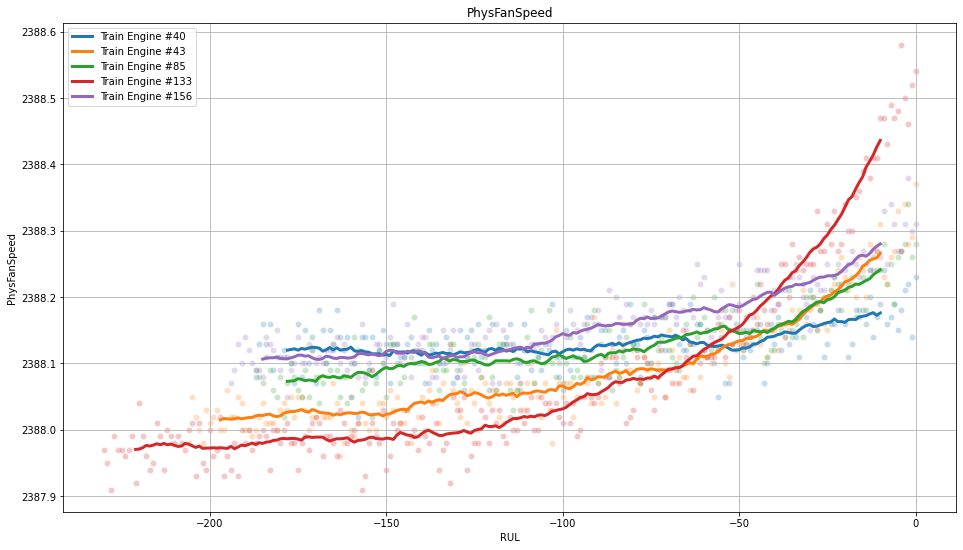

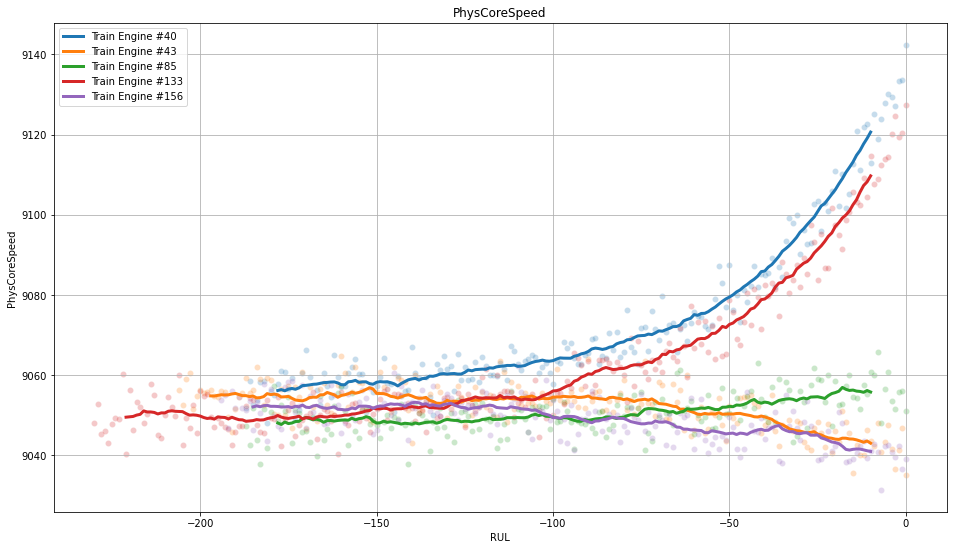

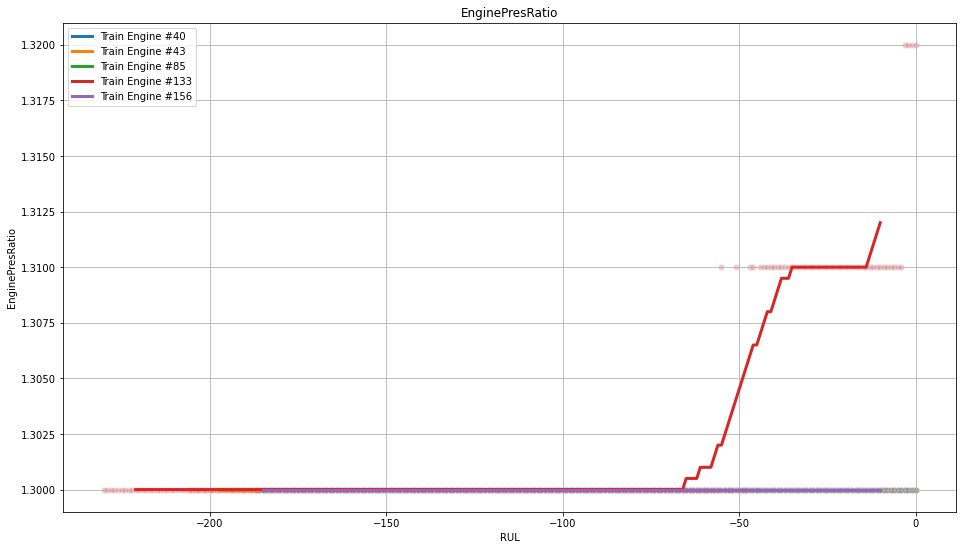

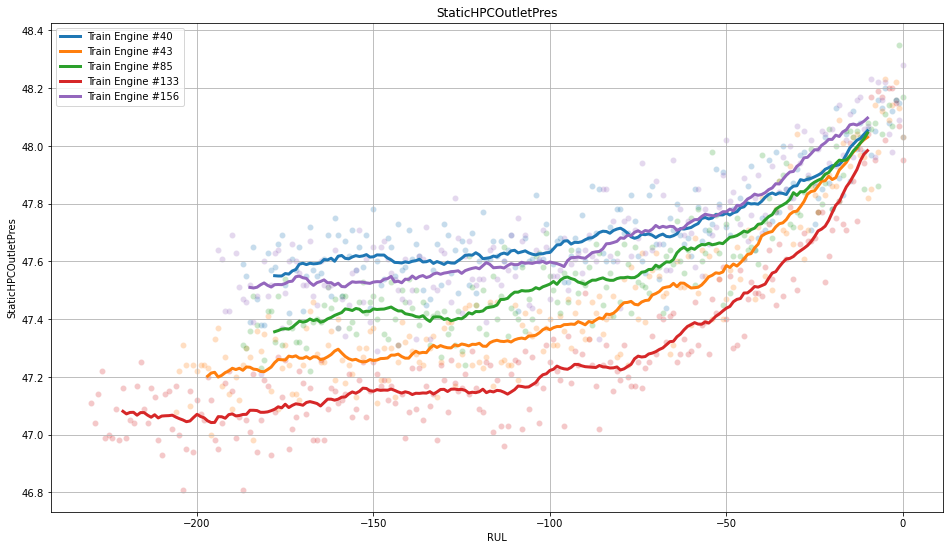

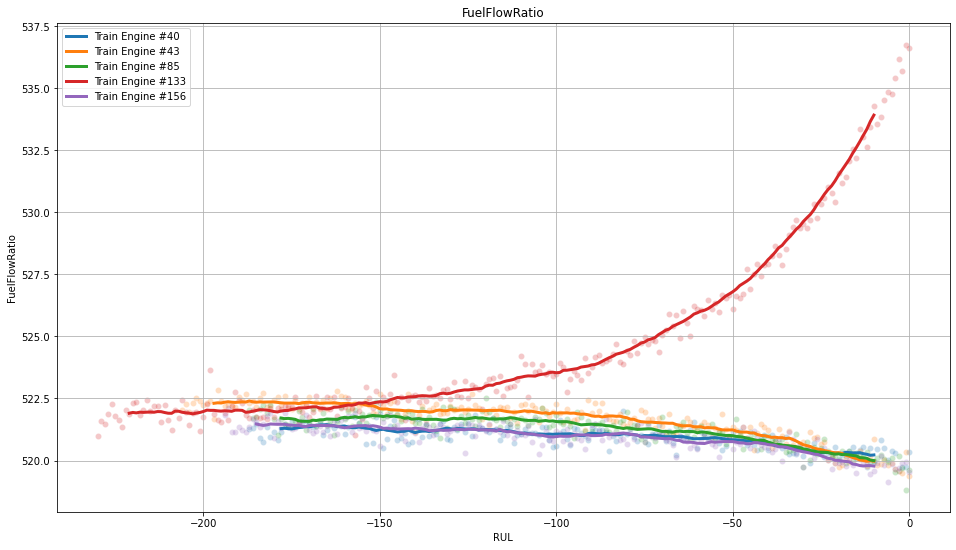

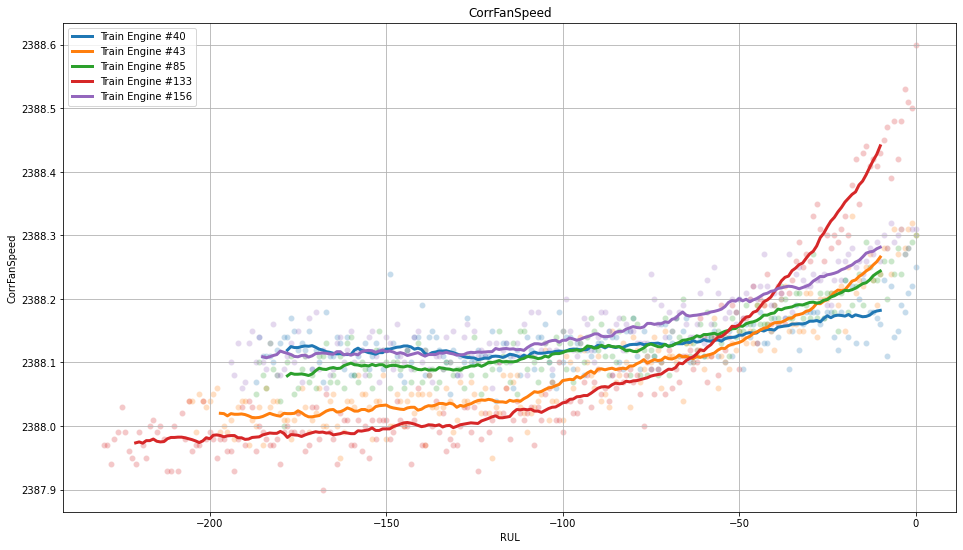

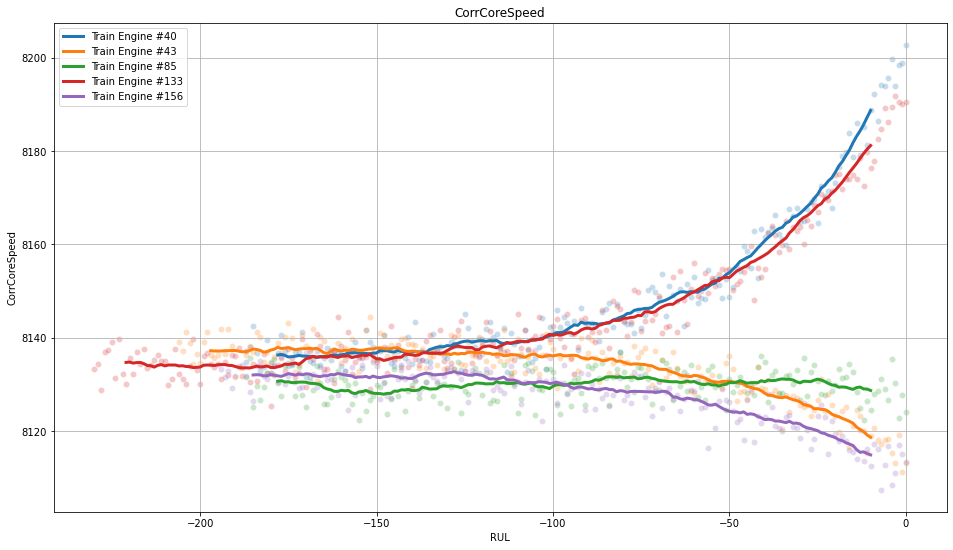

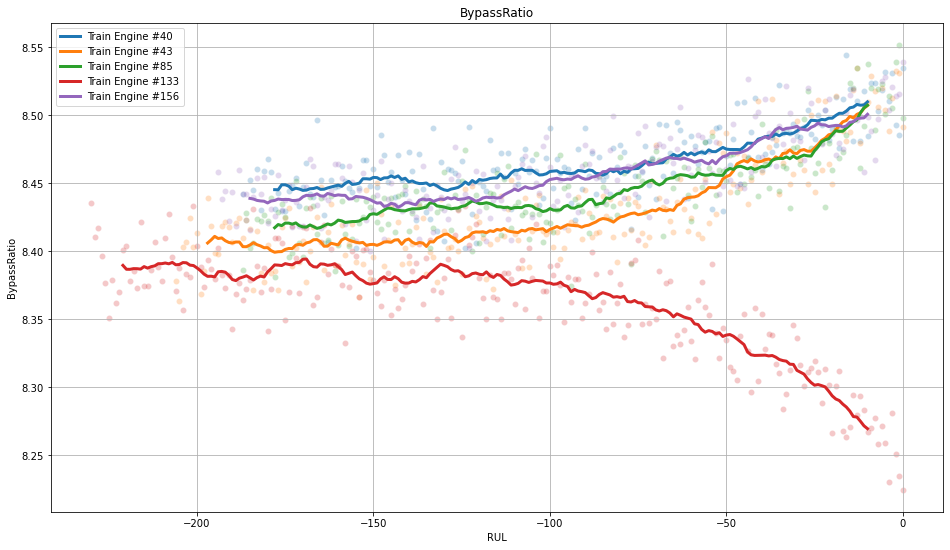

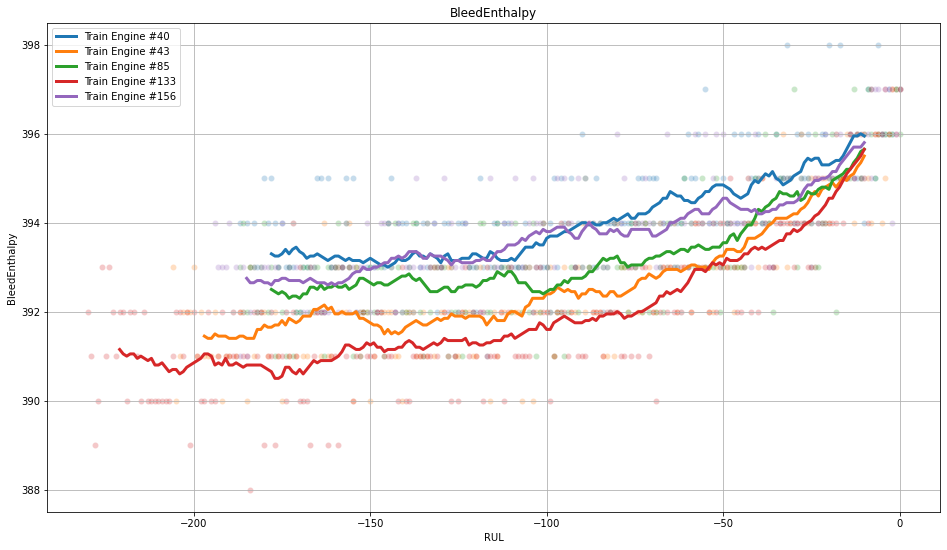

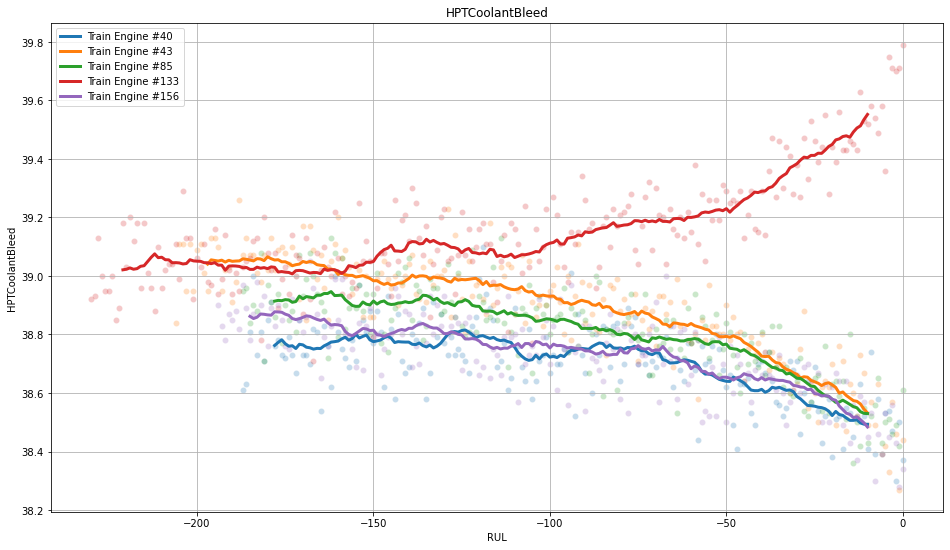

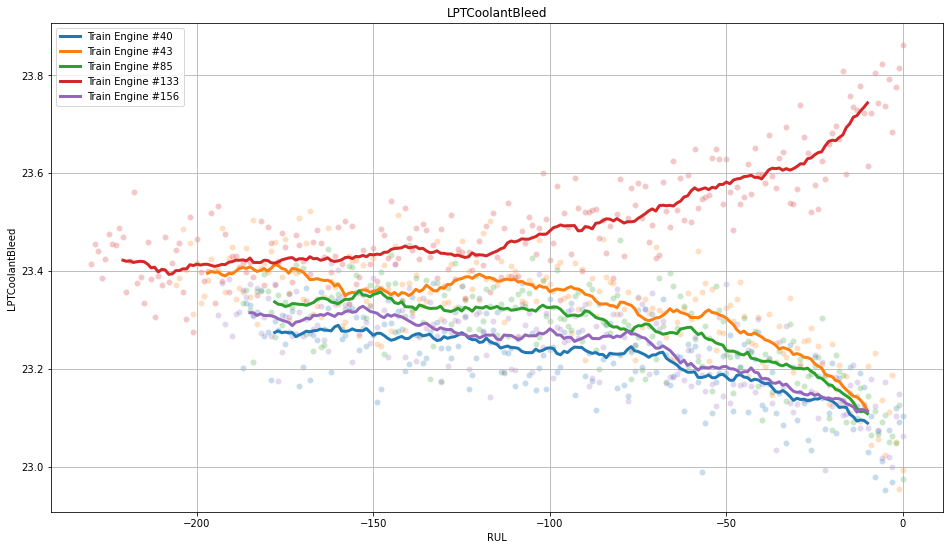

In [98]:
df_sample = train_df[train_df['Unit'].isin(np.random.choice(train_df['Unit'].unique(),6))]
df_sample = df_sample.loc[:,df_sample.apply(pd.Series.nunique) != 1]

for col in df_sample.columns[2:-1]:
    plt.figure(figsize=(16,9))
    ax = plt.gca()
    for unit in df_sample['Unit'].unique():
        tmp = df_sample[df_sample['Unit'] == unit]
        sns.scatterplot(x = -tmp['RUL'], y = tmp[col], alpha = 0.25, ax = ax)
        sns.lineplot(x = -tmp['RUL']-10, 
                     y = tmp[col].rolling(window=20).mean(), 
                     linewidth = 3, 
                     label = f'Train Engine #{unit}', 
                     ax = ax)
        plt.grid(True)
        plt.title(col)

    plt.show()

In [7]:
def attribute_creation(df):
    df_new = pd.DataFrame()
    for unit in df['Unit'].unique():
        df_tmp = df[df['Unit'] == unit].reset_index(False)
        for i in ['FanInletTemp','LPCOutletTemp', 'HPCOutletTemp', 'LPTOutletTemp', 'FanInletPres', 
                  'BypassDuctPres', 'TotalHPCOutletPres', 'PhysFanSpeed', 'PhysCoreSpeed', 
                  'EnginePresRatio', 'StaticHPCOutletPres', 'FuelFlowRatio', 'CorrFanSpeed',
                  'CorrCoreSpeed', 'BypassRatio', 'BurnerFuelAirRatio', 'BleedEnthalpy',
                  'DemandFanSpeed', 'DemandCorrFanSpeed', 'HPTCoolantBleed', 'LPTCoolantBleed']:
            df_tmp[f'{i}_MA'] = df_tmp[i].rolling(window=20).mean()
        df_new = pd.concat([df_new,df_tmp])
    df_new = df_new.dropna()
    df_new.drop(['index'], axis = 1, inplace=True)
    return df_new

In [138]:
def x_reshape(df, columns, sequence_length):
    data = df[columns].values
    num_elements = data.shape[0]
    for start, stop in zip(range(0, 
                                 num_elements-sequence_length), 
                           range(sequence_length,
                                 num_elements)):
        yield(data[start:stop, :])

def get_x_slices(df, feature_columns):
    # Reshape the data to (samples, time steps, features)
    feature_list = [list(x_reshape(df[df['Unit'] == i], feature_columns, 50)) 
                    for i in range(1, df['Unit'].nunique() + 1) if len(df[df['Unit']  == i]) > 50]
    feature_array = np.concatenate(list(feature_list), axis=0).astype(np.float64)

    length = len(feature_array) // 128
    return feature_array[:length*128]

def get_engine_id(df):
    label_list = [y_reshape(df[df['Unit'] == i], 50, columns  = ['Unit']) 
                  for i in range(1, df['Unit'].nunique()+1)]
    label_array = np.concatenate(label_list).astype(np.int64)
    length = len(label_array) // 128
    return label_array[:length* 128]

def y_reshape(df, sequence_length, columns=['RUL']):
    data = df[columns].values
    num_elements = data.shape[0]
    return(data[sequence_length:num_elements, :])
        
def get_y_slices(df):
    label_list = [y_reshape(df[df['Unit'] == i], 50) 
                  for i in range(1, df['Unit'].nunique()+1)]
    label_array = np.concatenate(label_list).astype(np.float64)
    length = len(label_array) // 128
    return label_array[:length*128]

In [139]:
train_df = attribute_creation(train_df)
test_df = attribute_creation(test_df)

In [140]:
feature_columns = train_df.drop(['RUL','Unit','Cycle'], axis = 1).columns
feature_columns

Index(['Setting1', 'Setting2', 'Setting3', 'FanInletTemp', 'LPCOutletTemp',
       'HPCOutletTemp', 'LPTOutletTemp', 'FanInletPres', 'BypassDuctPres',
       'TotalHPCOutletPres', 'PhysFanSpeed', 'PhysCoreSpeed',
       'EnginePresRatio', 'StaticHPCOutletPres', 'FuelFlowRatio',
       'CorrFanSpeed', 'CorrCoreSpeed', 'BypassRatio', 'BurnerFuelAirRatio',
       'BleedEnthalpy', 'DemandFanSpeed', 'DemandCorrFanSpeed',
       'HPTCoolantBleed', 'LPTCoolantBleed', 'FanInletTemp_MA',
       'LPCOutletTemp_MA', 'HPCOutletTemp_MA', 'LPTOutletTemp_MA',
       'FanInletPres_MA', 'BypassDuctPres_MA', 'TotalHPCOutletPres_MA',
       'PhysFanSpeed_MA', 'PhysCoreSpeed_MA', 'EnginePresRatio_MA',
       'StaticHPCOutletPres_MA', 'FuelFlowRatio_MA', 'CorrFanSpeed_MA',
       'CorrCoreSpeed_MA', 'BypassRatio_MA', 'BurnerFuelAirRatio_MA',
       'BleedEnthalpy_MA', 'DemandFanSpeed_MA', 'DemandCorrFanSpeed_MA',
       'HPTCoolantBleed_MA', 'LPTCoolantBleed_MA'],
      dtype='object')

In [141]:
X_train = get_x_slices(train_df, feature_columns)
X_train = MinMaxScaler().fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

X_train.shape

(31488, 50, 45)

In [142]:
y_train = get_y_slices(train_df)
y_train.shape

(31488, 1)

In [143]:
X_test = get_x_slices(test_df, feature_columns)
X_test = MinMaxScaler().fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_test.shape

(16256, 50, 45)

In [144]:
y_test = get_y_slices(test_df)
y_test.shape

(16256, 1)

In [17]:
model = Sequential()
model.add(LSTM(input_shape=(X_train.shape[1], X_train.shape[2]), units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=25, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Dropout(0.2))
model.add(Activation("linear"))

model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse','mae'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           58400     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 50)            30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 30)            9720      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 30)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 25)                5

In [19]:
es = EarlyStopping(monitor='val_mse',  
                   patience=10, 
                   verbose=True)

In [20]:
history = model.fit(X_train,
                    y_train,
                    epochs=999, 
                    validation_data=(X_test, 
                                     y_test), 

                    callbacks=[es])

Epoch 1/999
984/984 [==============================] - 78s 73ms/step - loss: 13003.9681 - mse: 13003.9681 - mae: 85.7252 - val_loss: 15210.9580 - val_mse: 15210.9580 - val_mae: 101.6114
Epoch 2/999
984/984 [==============================] - 70s 71ms/step - loss: 9755.6362 - mse: 9755.6362 - mae: 70.3958 - val_loss: 11757.0078 - val_mse: 11757.0078 - val_mae: 85.0089
Epoch 3/999
984/984 [==============================] - 70s 71ms/step - loss: 8597.4168 - mse: 8597.4168 - mae: 65.7958 - val_loss: 9684.6572 - val_mse: 9684.6572 - val_mae: 74.4454
Epoch 4/999
984/984 [==============================] - 67s 68ms/step - loss: 8029.9830 - mse: 8029.9830 - mae: 64.7491 - val_loss: 8573.2812 - val_mse: 8573.2812 - val_mae: 68.6965
Epoch 5/999
984/984 [==============================] - 68s 69ms/step - loss: 7755.2424 - mse: 7755.2424 - mae: 64.7727 - val_loss: 8101.4482 - val_mse: 8101.4482 - val_mae: 66.2614
Epoch 6/999
984/984 [==============================] - 71s 72ms/step - loss: 7686.7594 -

984/984 [==============================] - 71s 73ms/step - loss: 3639.8257 - mse: 3639.8257 - mae: 33.8987 - val_loss: 3079.0269 - val_mse: 3079.0269 - val_mae: 41.3632
Epoch 47/999
984/984 [==============================] - 72s 73ms/step - loss: 3718.9355 - mse: 3718.9355 - mae: 33.8125 - val_loss: 3522.4382 - val_mse: 3522.4382 - val_mae: 43.9408
Epoch 48/999
984/984 [==============================] - 73s 74ms/step - loss: 3670.3320 - mse: 3670.3320 - mae: 33.6907 - val_loss: 3009.2073 - val_mse: 3009.2073 - val_mae: 40.5142
Epoch 49/999
984/984 [==============================] - 72s 73ms/step - loss: 3700.5547 - mse: 3700.5547 - mae: 33.3155 - val_loss: 3292.1392 - val_mse: 3292.1392 - val_mae: 41.9711
Epoch 50/999
984/984 [==============================] - 72s 73ms/step - loss: 3512.9626 - mse: 3512.9626 - mae: 33.2844 - val_loss: 3248.8809 - val_mse: 3248.8809 - val_mae: 42.0348
Epoch 51/999
984/984 [==============================] - 73s 74ms/step - loss: 3468.5617 - mse: 3468.561

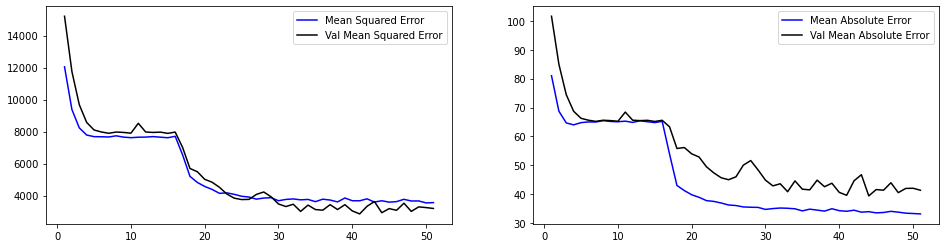

In [151]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(16,4))

ax1.plot(np.arange(1,len(history.history['loss']) + 1), history.history['loss'], color = 'blue', label = 'Mean Squared Error')
ax1.plot(np.arange(1,len(history.history['val_loss']) + 1), history.history['val_loss'], color = 'black', label = 'Val Mean Squared Error')
ax1.legend()
ax2.plot(np.arange(1,len(history.history['mae']) + 1), history.history['mae'], color = 'blue', label = 'Mean Absolute Error')
ax2.plot(np.arange(1,len(history.history['val_mae']) + 1), history.history['val_mae'], color = 'black', label = 'Val Mean Absolute Error')
ax2.legend();

In [21]:
pred = model.predict(X_test)

<AxesSubplot:>

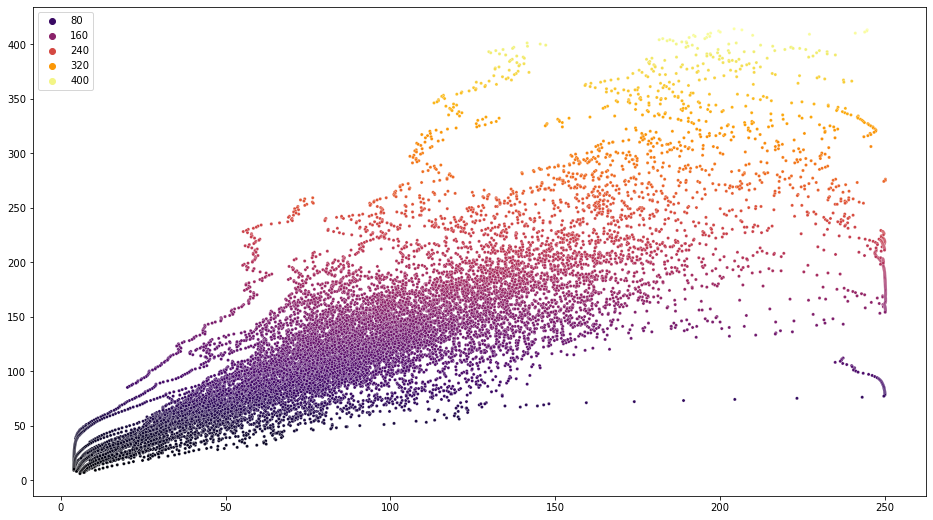

In [22]:
plt.figure(figsize=(16,9))
sns.scatterplot(x = pred.reshape(1,-1)[0], 
                y = y_test.reshape(1,-1)[0], 
                hue = y_test.reshape(1,-1)[0], 
                palette='inferno', 
                s = 10)

In [145]:
model.save("LSTMEngineRUL.h5")
model = load_model("LSTMEngineRUL.h5")

In [146]:
tmp = pd.DataFrame(get_engine_id(test_df))
tmp['RUL'] = get_y_slices(test_df)
tmp['pred'] = pred
tmp.columns = ['Unit','RUL','pred']

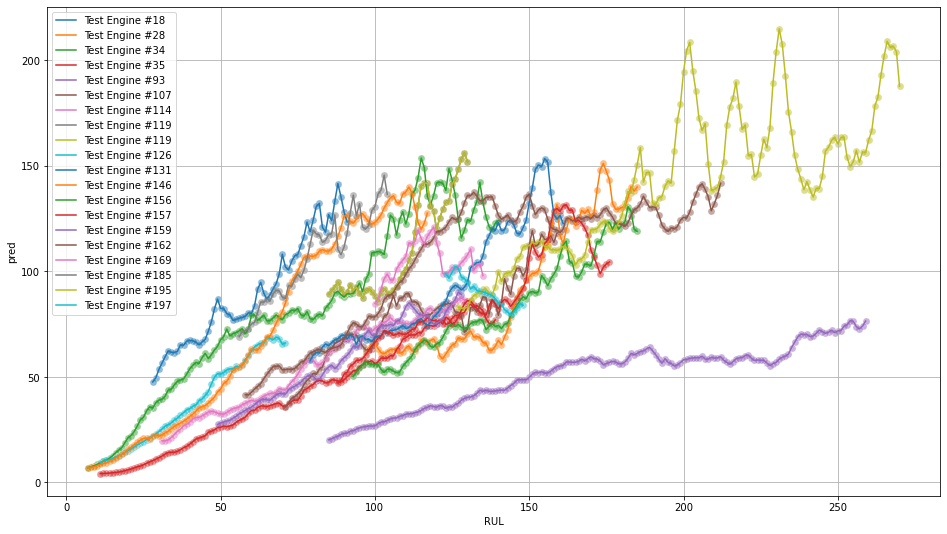

In [150]:
plt.figure(figsize=(16,9))
for i in sorted(np.random.choice(tmp['Unit'].unique(), 20)):
    tmp2 = tmp[tmp['Unit'] == i]
    sns.scatterplot(x = tmp2['RUL'], y = tmp2['pred'], s = 50, alpha = 0.5)
    sns.lineplot(x = tmp2['RUL'], y = tmp2['pred'], label = f"Test Engine #{i}")
    plt.grid(True)